## Itertation 4 BDAS

Eunju Yoon, 200520416, eyoo699@aucklanduni.ac.nz

### 01-BU

#### The objectives of the situation

• Analysis of climate change trends
    Analyze historical climate data to identify trends and patterns in temperature, sea level rise, and other relevant environmental indicators.
    Understanding these trends can help assess the magnitude and direction of climate change.

    
• Prediction of risks by climate change
    Develop predictive models to forecast future climate change risks and their potential impacts on cities in New Zealand.
    This includes predicting the likelihood of extreme events, identifying regions at higher risk, and estimating potential damage.

In [2]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType
from pyspark.sql.functions import corr
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 02-DU

#### Explore data

In [4]:
# Collect initial data
glacier_ice_volumes_data = spark.read.csv('dataset/annual-glacier-ice-volumes-1978-2020.csv', header = True, inferSchema = True)
sea_level_data = spark.read.csv('dataset/annual-mean-sea-level-relative-to-land-19002013.csv', header = True, inferSchema = True)
temperature_anomalies_data = spark.read.csv('dataset/global-and-new-zealand-temperature-anomalies-19092016.csv', header = True, inferSchema = True)
nz_temperature_data = spark.read.csv('dataset/new-zealands-national-temperature-19092016.csv', header = True, inferSchema = True)
sea_surface_temperature_data = spark.read.csv('dataset/oceanic-sea-surface-temperature-19932016.csv', header = True, inferSchema = True)
rainfall_intensity_data = spark.read.csv('dataset/rainfall-intensity-19602016.csv', header = True, inferSchema = True)

In [5]:
# Explore Data
glacier_ice_volumes_data.printSchema()

root
 |-- field_1: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- ice_volume: double (nullable = true)
 |-- unit: string (nullable = true)



In [11]:
# Annual glacier ice volumes
glacier_ice_volumes_data.show()

+-------+----+----------+----+
|field_1|year|ice_volume|unit|
+-------+----+----------+----+
|      1|1978|     53.29|km^3|
|      2|1979|     52.31|km^3|
|      3|1980|     52.31|km^3|
|      4|1981|     52.52|km^3|
|      5|1982|     52.13|km^3|
|      6|1983|     52.93|km^3|
|      7|1984|      53.6|km^3|
|      8|1985|     54.09|km^3|
|      9|1986|     54.12|km^3|
|     10|1987|     54.28|km^3|
|     11|1988|     54.03|km^3|
|     12|1989|     53.88|km^3|
|     13|1990|     52.01|km^3|
|     14|1991|     52.23|km^3|
|     15|1992|     52.96|km^3|
|     16|1993|      53.8|km^3|
|     17|1994|     54.21|km^3|
|     18|1995|     55.22|km^3|
|     19|1996|     55.39|km^3|
|     20|1997|     56.21|km^3|
+-------+----+----------+----+
only showing top 20 rows



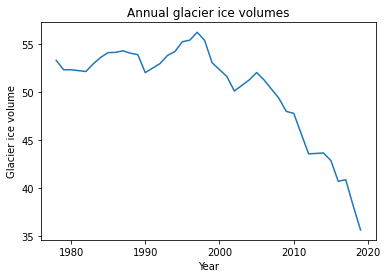

In [12]:
# Visualization for Annual glacier ice volumes
plot_data = glacier_ice_volumes_data.select('year','ice_volume').sample(False, 0.8).toPandas()
plt.plot(plot_data.year, plot_data.ice_volume)
plt.xlabel('Year')
plt.ylabel('Glacier ice volume')
plt.title('Annual glacier ice volumes')
plt.show()

In [13]:
# Annual sea level (relative to land)
sea_level_data.printSchema()

root
 |-- year: integer (nullable = true)
 |-- tide_gauge: string (nullable = true)
 |-- mean_sea_level_metres: double (nullable = true)



In [14]:
sea_level_data.show()

+----+------------+---------------------+
|year|  tide_gauge|mean_sea_level_metres|
+----+------------+---------------------+
|1899|Auckland_MSL|                1.866|
|1900|Auckland_MSL|                1.863|
|1901|Auckland_MSL|                1.823|
|1902|Auckland_MSL|                  0.0|
|1903|Auckland_MSL|                 1.88|
|1904|Auckland_MSL|                1.864|
|1905|Auckland_MSL|                1.843|
|1906|Auckland_MSL|                1.826|
|1907|Auckland_MSL|                1.882|
|1908|Auckland_MSL|                 1.92|
|1909|Auckland_MSL|                1.901|
|1910|Auckland_MSL|                1.928|
|1911|Auckland_MSL|                1.948|
|1912|Auckland_MSL|                1.903|
|1913|Auckland_MSL|                1.873|
|1914|Auckland_MSL|                1.833|
|1915|Auckland_MSL|                1.875|
|1916|Auckland_MSL|                1.928|
|1917|Auckland_MSL|                1.923|
|1918|Auckland_MSL|                1.905|
+----+------------+---------------

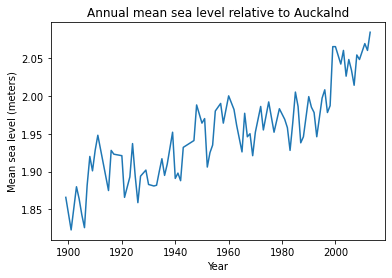

In [15]:
# Visualization for Annual mean sea level relative to Auckaland
plot_data = sea_level_data.filter('tide_gauge == "Auckland_MSL"').filter('mean_sea_level_metres > 0').select('year','mean_sea_level_metres').sample(False, 0.8).toPandas()
plt.plot(plot_data.year, plot_data.mean_sea_level_metres)
plt.xlabel("Year")
plt.ylabel("Mean sea level (meters)")
plt.title("Annual mean sea level relative to Auckalnd")
plt.show()

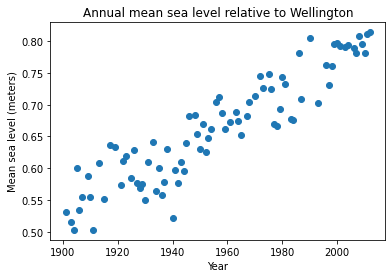

In [22]:
# Visualization for Annual mean sea level relative to Wellingtion
plot_data = sea_level_data.filter('tide_gauge == "Wellington"').filter('mean_sea_level_metres > 0').select('year','mean_sea_level_metres').sample(False, 0.8).toPandas()
plt.scatter(plot_data.year, plot_data.mean_sea_level_metres)
plt.xlabel("Year")
plt.ylabel("Mean sea level (meters)")
plt.title("Annual mean sea level relative to Wellington")
plt.show()

In [23]:
# Global and New Zealand’s temperature anomalies (1900-2020)
temperature_anomalies_data.printSchema()

root
 |-- Dataset: string (nullable = true)
 |-- Spatial_coverage: string (nullable = true)
 |-- Statistic: string (nullable = true)
 |-- Start_year: integer (nullable = true)
 |-- End_year: integer (nullable = true)
 |-- Temperature_degrees_celcius: double (nullable = true)
 |-- field_7: string (nullable = true)



In [24]:
temperature_anomalies_data.show()

+--------------------+----------------+--------------------+----------+--------+---------------------------+-------+
|             Dataset|Spatial_coverage|           Statistic|Start_year|End_year|Temperature_degrees_celcius|field_7|
+--------------------+----------------+--------------------+----------+--------+---------------------------+-------+
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1909|    1909|                      -0.22|   null|
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1910|    1910|                      -0.15|   null|
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1911|    1911|                      -0.66|   null|
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1912|    1912|                      -1.28|   null|
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1913|    1913|                      -1.04|   null|
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|    

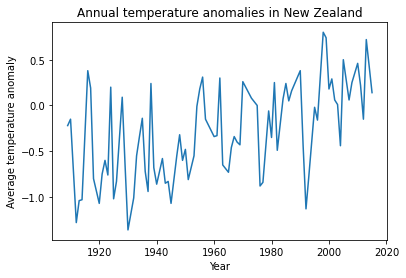

In [25]:
# Visualization for New Zealand’s temperature anomalies (1900-2020)
plot_data = temperature_anomalies_data.filter('Dataset == "NZ_7_station_temperature_time_series"').filter('Statistic == "Average_temperature_anomaly"').select('End_year','Temperature_degrees_celcius').sample(False, 0.8).toPandas()
plt.plot(plot_data.End_year, plot_data.Temperature_degrees_celcius)
plt.xlabel("Year")
plt.ylabel("Average temperature anomaly")
plt.title("Annual temperature anomalies in New Zealand")
plt.show()

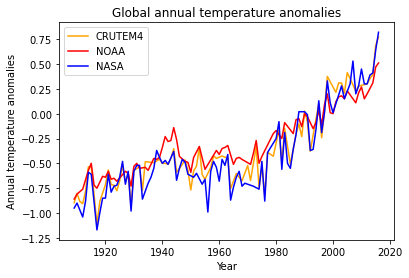

In [26]:
# Visualization for Global temperature anomalies (1900-2020)
plot_data_CRUTEM4 = temperature_anomalies_data.filter('Dataset == "Climatic_Research_Unit_(CRUTEM4)"').filter('Statistic == "Average_temperature_anomaly"').select('End_year','Temperature_degrees_celcius').sample(False, 0.8).toPandas()
plt.plot(plot_data_CRUTEM4.End_year, plot_data_CRUTEM4.Temperature_degrees_celcius, color = 'orange', label = 'CRUTEM4')

plot_data_NOAA = temperature_anomalies_data.filter('Dataset == "National_Oceanic_and_Atmospheric_Administration_(NOAA)"').filter('Statistic == "Average_temperature_anomaly"').select('End_year','Temperature_degrees_celcius').sample(False, 0.8).toPandas()
plt.plot(plot_data_NOAA.End_year, plot_data_NOAA.Temperature_degrees_celcius, color = 'red', label = 'NOAA')

plot_data_NASA = temperature_anomalies_data.filter('Dataset == "National_Aeronautics_and_Space_Administration_(NASA)"').filter('Statistic == "Average_temperature_anomaly"').select('End_year','Temperature_degrees_celcius').sample(False, 0.8).toPandas()
plt.plot(plot_data_NASA.End_year, plot_data_NASA.Temperature_degrees_celcius, color = 'blue', label = 'NASA')

plt.xlabel("Year")
plt.ylabel("Annual temperature anomalies")
plt.title("Global annual temperature anomalies")
plt.legend()
plt.show()

In [27]:
# New Zealand's national temperature (1909–2016)
nz_temperature_data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Statistic: string (nullable = true)
 |-- Temperature_degrees_celcius: double (nullable = true)



In [28]:
nz_temperature_data.show()

+----+--------------------+---------------------------+
|Year|           Statistic|Temperature_degrees_celcius|
+----+--------------------+---------------------------+
|1909|National_average_...|                      12.39|
|1910|National_average_...|                      12.46|
|1911|National_average_...|                      11.95|
|1912|National_average_...|                      11.33|
|1913|National_average_...|                      11.57|
|1914|National_average_...|                      11.58|
|1915|National_average_...|                      11.94|
|1916|National_average_...|                      12.99|
|1917|National_average_...|                       12.8|
|1918|National_average_...|                      11.81|
|1919|National_average_...|                      11.39|
|1920|National_average_...|                      11.54|
|1921|National_average_...|                      11.86|
|1922|National_average_...|                      12.01|
|1923|National_average_...|                     

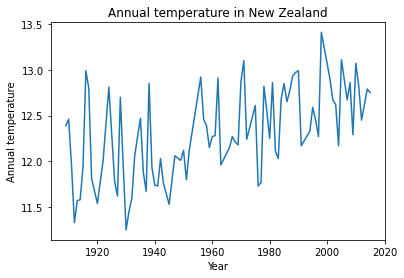

In [33]:
# Visualization for New Zealand's national temperature (1909–2016)
plot_data = nz_temperature_data.filter('Statistic == "National_average_temperature"').select('Year','Temperature_degrees_celcius').sample(False, 0.8).toPandas()
plt.plot(plot_data.Year, plot_data.Temperature_degrees_celcius)
plt.xlabel("Year")
plt.ylabel("Annual temperature")
plt.title("Annual temperature in New Zealand")
plt.show()

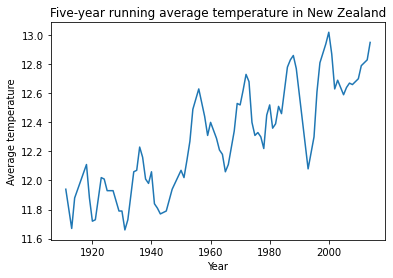

In [36]:
# Visualization for New Zealand's national temperature (1909–2016)
plot_data = nz_temperature_data.filter('Statistic == "Five-year_running_average_temperature"').select('Year','Temperature_degrees_celcius').sample(False, 0.8).toPandas()
plt.plot(plot_data.Year, plot_data.Temperature_degrees_celcius)
plt.xlabel("Year")
plt.ylabel("Average temperature")
plt.title("Five-year running average temperature in New Zealand")
plt.show()

In [37]:
# Sea surface mean temperature in New Zealand (1993-2016)
sea_surface_temperature_data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Area: string (nullable = true)
 |-- Variable: string (nullable = true)
 |-- Statistic: string (nullable = true)
 |-- Value: double (nullable = true)



In [38]:
sea_surface_temperature_data.show()

+----+--------------------+--------------------+---------+-------+
|Year|                Area|            Variable|Statistic|  Value|
+----+--------------------+--------------------+---------+-------+
|1993|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.3612|
|1994|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.4678|
|1995|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.5782|
|1996|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean| 14.649|
|1997|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.4728|
|1998|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean| 14.632|
|1999|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|15.0981|
|2000|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.8112|
|2001|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.8066|
|2002|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.8327|
|2003|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.7494|
|2004|New_Zealand_ocean...|Oceanic_sea_surfa...|     Mean|14.5

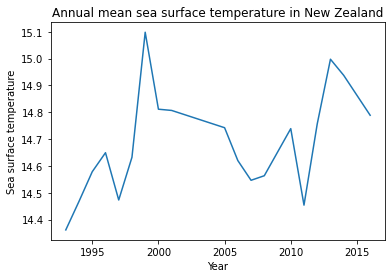

In [23]:
# Visualization for Sea surface mean temperature in New Zealand (1993-2016)
plot_data = sea_surface_temperature_data.filter('Area == "New_Zealand_oceanic_waters"').filter('Variable == "Oceanic_sea_surface_temperature"').filter('Statistic == "Mean"').select('Year','Value').sample(False, 0.8).toPandas()

plt.plot(plot_data.Year, plot_data.Value)
plt.xlabel("Year")
plt.ylabel("Sea surface temperature")
plt.title("Annual mean sea surface temperature in New Zealand")
plt.show()

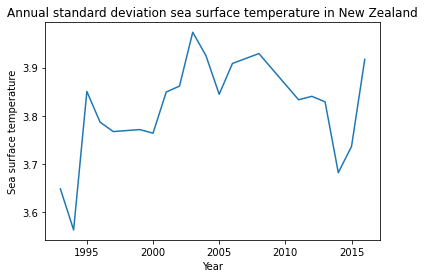

In [24]:
# Visualization for Sea surface stasndard deviation temperature in New Zealand (1993-2016)
plot_data = sea_surface_temperature_data.filter('Area == "New_Zealand_oceanic_waters"').filter('Variable == "Oceanic_sea_surface_temperature"').filter('Statistic == "Standard_Deviation"').select('Year','Value').sample(False, 0.8).toPandas()

plt.plot(plot_data.Year, plot_data.Value)
plt.xlabel("Year")
plt.ylabel("Sea surface temperature")
plt.title("Annual standard deviation sea surface temperature in New Zealand")
plt.show()

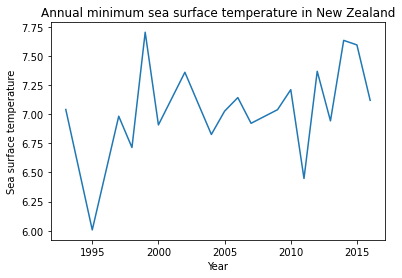

In [25]:
# Visualization for Sea surface minimum temperature in New Zealand (1993-2016)
plot_data = sea_surface_temperature_data.filter('Area == "New_Zealand_oceanic_waters"').filter('Variable == "Oceanic_sea_surface_temperature"').filter('Statistic == "Minimum"').select('Year','Value').sample(False, 0.8).toPandas()

plt.plot(plot_data.Year, plot_data.Value)
plt.xlabel("Year")
plt.ylabel("Sea surface temperature")
plt.title("Annual minimum sea surface temperature in New Zealand")
plt.show()

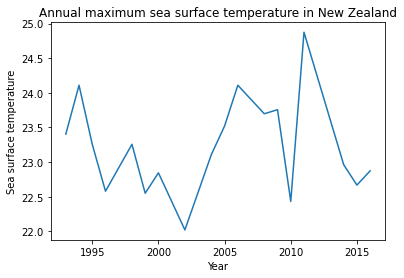

In [26]:
# Visualization for Sea surface maximum temperature in New Zealand (1993-2016)
plot_data = sea_surface_temperature_data.filter('Area == "New_Zealand_oceanic_waters"').filter('Variable == "Oceanic_sea_surface_temperature"').filter('Statistic == "Maximum"').select('Year','Value').sample(False, 0.8).toPandas()

plt.plot(plot_data.Year, plot_data.Value)
plt.xlabel("Year")
plt.ylabel("Sea surface temperature")
plt.title("Annual maximum sea surface temperature in New Zealand")
plt.show()

In [39]:
# Rainfall intensity
rainfall_intensity_data.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- site: string (nullable = true)
 |-- r95ptot: double (nullable = true)
 |-- rx1day: double (nullable = true)



In [40]:
rainfall_intensity_data.show()

+----+--------+-----------+------+
|Year|    site|    r95ptot|rx1day|
+----+--------+-----------+------+
|1960|Auckland|        0.0|   0.0|
|1961|Auckland|        0.0|   0.0|
|1962|Auckland|        0.0|   0.0|
|1963|Auckland|34.24417406|  56.4|
|1964|Auckland|31.89158016|  44.7|
|1965|Auckland|33.39581615|  70.4|
|1966|Auckland|31.24754034|  66.5|
|1967|Auckland|37.46610796| 139.4|
|1968|Auckland|19.86384634|  58.4|
|1969|Auckland| 26.7946185|  58.9|
|1970|Auckland| 32.9884955|  80.3|
|1971|Auckland|27.30793479|  64.7|
|1972|Auckland|27.95676998|  68.5|
|1973|Auckland|16.12903226|  65.1|
|1974|Auckland|23.75152253|  38.0|
|1975|Auckland|21.20684919|  88.8|
|1976|Auckland|35.94574228|  97.0|
|1977|Auckland| 17.5311305|  71.0|
|1978|Auckland|20.92925026|  56.0|
|1979|Auckland|39.40422067|  87.6|
+----+--------+-----------+------+
only showing top 20 rows



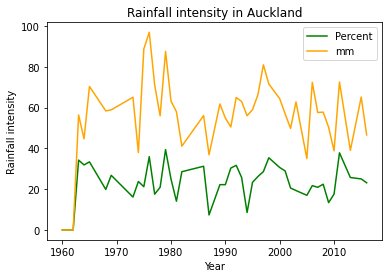

In [29]:
# Visualization for Rainfall intensity in Auckland
plot_data = rainfall_intensity_data.filter('site == "Auckland"').select('Year','r95ptot', 'rx1day').sample(False, 0.8).toPandas()

plt.plot(plot_data.Year, plot_data.r95ptot, color = 'green', label = "Percent")
plt.plot(plot_data.Year, plot_data.rx1day, color = 'orange', label = "mm")
plt.xlabel("Year")
plt.ylabel("Rainfall intensity")
plt.title("Rainfall intensity in Auckland")
plt.legend()
plt.show()

#### Data quality

In [30]:
# Annual glacier ice volumes
glacier_ice_volumes_data.describe().show()

+-------+------------------+------------------+------------------+----+
|summary|           field_1|              year|        ice_volume|unit|
+-------+------------------+------------------+------------------+----+
|  count|                43|                43|                43|  43|
|   mean|              22.0|            1999.0|49.838837209302305|null|
| stddev|12.556538801224908|12.556538801224908| 5.537926468282717|null|
|    min|                 1|              1978|              34.6|km^3|
|    max|                43|              2020|             56.21|km^3|
+-------+------------------+------------------+------------------+----+



In [31]:
glacier_ice_volumes_data.filter('ice_volume == 0').select('*').show()

+-------+----+----------+----+
|field_1|year|ice_volume|unit|
+-------+----+----------+----+
+-------+----+----------+----+



In [32]:
# Annual sea level (relative to land)
sea_level_data.describe().show()

+-------+-----------------+------------+---------------------+
|summary|             year|  tide_gauge|mean_sea_level_metres|
+-------+-----------------+------------+---------------------+
|  count|              575|         575|                  575|
|   mean|           1956.0|        null|   1.0499895652173907|
| stddev|33.22528947394124|        null|   0.6729432854231862|
|    min|             1899|Auckland_MSL|                  0.0|
|    max|             2013|  Wellington|                2.088|
+-------+-----------------+------------+---------------------+



In [33]:
missing_data_in_sea_level_data = sea_level_data.filter('mean_sea_level_metres == 0').select('*')
missing_data_in_sea_level_data.show()
print("The number of missing values: ", missing_data_in_sea_level_data.count())

+----+------------+---------------------+
|year|  tide_gauge|mean_sea_level_metres|
+----+------------+---------------------+
|1902|Auckland_MSL|                  0.0|
|1946|Auckland_MSL|                  0.0|
|1904| Dunedin_MSL|                  0.0|
|1916| Dunedin_MSL|                  0.0|
|1917| Dunedin_MSL|                  0.0|
|1920| Dunedin_MSL|                  0.0|
|1922| Dunedin_MSL|                  0.0|
|1928| Dunedin_MSL|                  0.0|
|1930| Dunedin_MSL|                  0.0|
|1931| Dunedin_MSL|                  0.0|
|1933| Dunedin_MSL|                  0.0|
|1934| Dunedin_MSL|                  0.0|
|1943| Dunedin_MSL|                  0.0|
|1953| Dunedin_MSL|                  0.0|
|1981| Dunedin_MSL|                  0.0|
|1982| Dunedin_MSL|                  0.0|
|1991| Dunedin_MSL|                  0.0|
|1992| Dunedin_MSL|                  0.0|
|1993| Dunedin_MSL|                  0.0|
|1994| Dunedin_MSL|                  0.0|
+----+------------+---------------

In [8]:
# Global and New Zealand temperature anomalies
temperature_anomalies_data.describe().show()

+-------+--------------------+----------------+--------------------+------------------+------------------+---------------------------+-------+
|summary|             Dataset|Spatial_coverage|           Statistic|        Start_year|          End_year|Temperature_degrees_celcius|field_7|
+-------+--------------------+----------------+--------------------+------------------+------------------+---------------------------+-------+
|  count|                 848|             848|                 848|               848|               848|                        848|      0|
|   mean|                null|            null|                null|1961.5188679245282|1963.4811320754718|       -0.35431227712264174|   null|
| stddev|                null|            null|                null|30.648937612208254|30.648937612208318|        0.38472487245810844|   null|
|    min|Climatic_Research...|          Global|Average_temperatu...|              1909|              1909|                      -1.36|   null|

In [9]:
missing_data_in_temperature_anomalies_data = temperature_anomalies_data.filter('Dataset == "NZ_7_station_temperature_time_series"').filter('Statistic == "Average_temperature_anomaly"').filter('Temperature_degrees_celcius == 0').select('*')
missing_data_in_temperature_anomalies_data.show()
print("The number of missing values: ", missing_data_in_temperature_anomalies_data.count())

+--------------------+----------------+--------------------+----------+--------+---------------------------+-------+
|             Dataset|Spatial_coverage|           Statistic|Start_year|End_year|Temperature_degrees_celcius|field_7|
+--------------------+----------------+--------------------+----------+--------+---------------------------+-------+
|NZ_7_station_temp...|     New_Zealand|Average_temperatu...|      1975|    1975|                        0.0|   null|
+--------------------+----------------+--------------------+----------+--------+---------------------------+-------+

The number of missing values:  1


In [10]:
# New Zealand's national temperature
nz_temperature_data.describe().show()

+-------+-----------------+--------------------+---------------------------+
|summary|             Year|           Statistic|Temperature_degrees_celcius|
+-------+-----------------+--------------------+---------------------------+
|  count|              424|                 424|                        424|
|   mean|           1962.5|                null|          5.993183962264144|
| stddev|30.65070506595527|                null|           6.32730833267697|
|    min|             1909|Five-year_running...|                      -1.36|
|    max|             2016|National_average_...|                      13.44|
+-------+-----------------+--------------------+---------------------------+



In [11]:
missing_data_in_nz_temperature_data = nz_temperature_data.filter('Statistic == "National_average_temperature"').filter('Temperature_degrees_celcius == 0').select('*')
missing_data_in_nz_temperature_data.show()

+----+---------+---------------------------+
|Year|Statistic|Temperature_degrees_celcius|
+----+---------+---------------------------+
+----+---------+---------------------------+



In [12]:
# Oceanic sea surface temperature
sea_surface_temperature_data.describe().show()

+-------+-----------------+--------------------+--------------------+------------------+------------------+
|summary|             Year|                Area|            Variable|         Statistic|             Value|
+-------+-----------------+--------------------+--------------------+------------------+------------------+
|  count|              960|                 960|                 960|               960|               960|
|   mean|           2004.5|                null|                null|              null| 525637.5100354946|
| stddev|6.925794677019939|                null|                null|              null|1442978.8746969604|
|    min|             1993|New_Zealand_ocean...|Oceanic_sea_surfa...|           Maximum|          -9.72997|
|    max|             2016|          Tasman_Sea|Oceanic_sea_surfa...|Standard_Deviation|         6451441.0|
+-------+-----------------+--------------------+--------------------+------------------+------------------+



In [39]:
missing_data_in_sea_surface_temperature_data = sea_surface_temperature_data.filter('Area == "New_Zealand_oceanic_waters"').filter('Variable == "Oceanic_sea_surface_temperature"').filter('Statistic == "Mean"').filter('Value == 0').select('*')
missing_data_in_sea_surface_temperature_data.show()

+----+----+--------+---------+-----+
|Year|Area|Variable|Statistic|Value|
+----+----+--------+---------+-----+
+----+----+--------+---------+-----+



In [13]:
# Rainfall Intensity
rainfall_intensity_data.describe().show()

+-------+------------------+---------+------------------+-----------------+
|summary|              Year|     site|           r95ptot|           rx1day|
+-------+------------------+---------+------------------+-----------------+
|  count|              1710|     1710|              1710|             1710|
|   mean|            1988.0|     null|21.915701822702342|67.27411646198829|
| stddev|16.456762861672175|     null|11.099378108277325|54.25926910966994|
|    min|              1960|    0pier|               0.0|              0.0|
|    max|              2016|Whangarei|       54.01682311|            537.5|
+-------+------------------+---------+------------------+-----------------+



In [14]:
missing_data_in_rainfall_intensity_data = rainfall_intensity_data.filter('site == "Auckland"').filter('r95ptot == 0').filter('rx1day == 0').select('*')
missing_data_in_rainfall_intensity_data.show()
print("The number of missing values: ", missing_data_in_rainfall_intensity_data.count())

+----+--------+-------+------+
|Year|    site|r95ptot|rx1day|
+----+--------+-------+------+
|1960|Auckland|    0.0|   0.0|
|1961|Auckland|    0.0|   0.0|
|1962|Auckland|    0.0|   0.0|
+----+--------+-------+------+

The number of missing values:  3


### 03-DP
#### Select data (rows & columns)

In [7]:
glacier_ice = glacier_ice_volumes_data.filter('year >= 1993').filter('year <= 2013').select('year', 'ice_volume')
glacier_ice.describe().show()

+-------+------------------+------------------+
|summary|              year|        ice_volume|
+-------+------------------+------------------+
|  count|                21|                21|
|   mean|            2003.0| 50.94238095238095|
| stddev|6.2048368229954285|3.6954443640270167|
|    min|              1993|             43.57|
|    max|              2013|             56.21|
+-------+------------------+------------------+



In [8]:
auckland_sea_level = sea_level_data.filter('year >= 1993').filter('year <= 2013').filter('tide_gauge == "Auckland_MSL"').select('year', 'mean_sea_level_metres')
auckland_sea_level.describe().show()

+-------+------------------+---------------------+
|summary|              year|mean_sea_level_metres|
+-------+------------------+---------------------+
|  count|                21|                   21|
|   mean|            2003.0|    2.029761904761905|
| stddev|6.2048368229954285|   0.0416940100756749|
|    min|              1993|                1.944|
|    max|              2013|                2.088|
+-------+------------------+---------------------+



In [9]:
avg_temperature_anomalies = temperature_anomalies_data.filter('End_year >= 1993').filter('End_year <= 2013').filter('Dataset == "NZ_7_station_temperature_time_series"').filter('Statistic == "Average_temperature_anomaly"').select('End_year', 'Temperature_degrees_celcius')
avg_temperature_anomalies.describe().show()

+-------+------------------+---------------------------+
|summary|          End_year|Temperature_degrees_celcius|
+-------+------------------+---------------------------+
|  count|                21|                         21|
|   mean|            2003.0|        0.07666666666666669|
| stddev|6.2048368229954285|        0.41519071922832446|
|    min|              1993|                      -0.77|
|    max|              2013|                        0.8|
+-------+------------------+---------------------------+



In [10]:
avg_temperature = nz_temperature_data.filter('Year >= 1993').filter('Year <= 2013').filter('Statistic == "National_average_temperature"').select('Year', 'Temperature_degrees_celcius')
avg_temperature.describe().show()

+-------+------------------+---------------------------+
|summary|              Year|Temperature_degrees_celcius|
+-------+------------------+---------------------------+
|  count|                21|                         21|
|   mean|            2003.0|         12.685714285714285|
| stddev|6.2048368229954285|        0.41596359730836335|
|    min|              1993|                      11.84|
|    max|              2013|                      13.41|
+-------+------------------+---------------------------+



In [11]:
avg_sea_surface_temperature = sea_surface_temperature_data.filter('Year >= 1993').filter('Year <= 2013').filter('Area == "New_Zealand_oceanic_waters"').filter('Statistic == "Mean"').select('Year', 'Value')
avg_sea_surface_temperature.describe().show()

+-------+------------------+------------------+
|summary|              Year|             Value|
+-------+------------------+------------------+
|  count|                21|                21|
|   mean|            2003.0|           14.6637|
| stddev|6.2048368229954285|0.1842655420853289|
|    min|              1993|           14.3612|
|    max|              2013|           15.0981|
+-------+------------------+------------------+



In [12]:
auckland_rainfall = rainfall_intensity_data.filter('Year >= 1993').filter('Year <= 2013').filter('site == "Auckland"').select('Year', 'r95ptot', 'rx1day')
auckland_rainfall.describe().show()

+-------+------------------+------------------+------------------+
|summary|              Year|           r95ptot|            rx1day|
+-------+------------------+------------------+------------------+
|  count|                21|                21|                21|
|   mean|            2003.0|24.144083753952383| 59.37142857142856|
| stddev|6.2048368229954285| 7.120506044203708|13.379280356474437|
|    min|              1993|       8.549147973|              35.0|
|    max|              2013|       37.82564401|              84.8|
+-------+------------------+------------------+------------------+



#### Clean data

In [12]:
glacier_ice.show(30)

+----+----------+
|year|ice_volume|
+----+----------+
|1993|      53.8|
|1994|     54.21|
|1995|     55.22|
|1996|     55.39|
|1997|     56.21|
|1998|     55.36|
|1999|     53.04|
|2000|     51.04|
|2001|     51.61|
|2002|      50.1|
|2003|     50.69|
|2004|     51.25|
|2005|     52.02|
|2006|     51.25|
|2007|     51.07|
|2008|     49.35|
|2009|     47.98|
|2010|     47.78|
|2011|     45.24|
|2012|     43.57|
|2013|     43.61|
+----+----------+



In [14]:
auckland_sea_level.show(30)

+----+---------------------+
|year|mean_sea_level_metres|
+----+---------------------+
|1993|                1.946|
|1994|                1.944|
|1995|                1.997|
|1996|                2.008|
|1997|                1.978|
|1998|                1.987|
|1999|                2.065|
|2000|                2.065|
|2001|                2.088|
|2002|                2.042|
|2003|                 2.06|
|2004|                2.026|
|2005|                2.048|
|2006|                2.034|
|2007|                2.014|
|2008|                2.054|
|2009|                2.048|
|2010|                2.008|
|2011|                2.069|
|2012|                 2.06|
|2013|                2.084|
+----+---------------------+



In [15]:
avg_temperature_anomalies.show(30)

+--------+---------------------------+
|End_year|Temperature_degrees_celcius|
+--------+---------------------------+
|    1993|                      -0.77|
|    1994|                      -0.28|
|    1995|                      -0.02|
|    1996|                      -0.16|
|    1997|                      -0.33|
|    1998|                        0.8|
|    1999|                       0.74|
|    2000|                       0.18|
|    2001|                       0.29|
|    2002|                       0.06|
|    2003|                       0.01|
|    2004|                      -0.44|
|    2005|                        0.5|
|    2006|                      -0.21|
|    2007|                       0.06|
|    2008|                       0.25|
|    2009|                      -0.32|
|    2010|                       0.46|
|    2011|                       0.22|
|    2012|                      -0.15|
|    2013|                       0.72|
+--------+---------------------------+



In [16]:
avg_temperature.show(30)

+----+---------------------------+
|Year|Temperature_degrees_celcius|
+----+---------------------------+
|1993|                      11.84|
|1994|                      12.33|
|1995|                      12.59|
|1996|                      12.45|
|1997|                      12.27|
|1998|                      13.41|
|1999|                      13.35|
|2000|                      12.79|
|2001|                       12.9|
|2002|                      12.67|
|2003|                      12.62|
|2004|                      12.17|
|2005|                      13.11|
|2006|                       12.4|
|2007|                      12.67|
|2008|                      12.86|
|2009|                      12.29|
|2010|                      13.07|
|2011|                      12.83|
|2012|                      12.45|
|2013|                      13.33|
+----+---------------------------+



In [17]:
avg_sea_surface_temperature.show(30)

+----+-------+
|Year|  Value|
+----+-------+
|1993|14.3612|
|1994|14.4678|
|1995|14.5782|
|1996| 14.649|
|1997|14.4728|
|1998| 14.632|
|1999|15.0981|
|2000|14.8112|
|2001|14.8066|
|2002|14.8327|
|2003|14.7494|
|2004|14.5186|
|2005|14.7422|
|2006|14.6198|
|2007|14.5462|
|2008|14.5632|
|2009|14.5427|
|2010|14.7388|
|2011|14.4536|
|2012|14.7561|
|2013|14.9975|
+----+-------+



In [18]:
auckland_rainfall.show(30)

+----+-----------+------+
|Year|    r95ptot|rx1day|
+----+-----------+------+
|1993|25.68454962|  63.0|
|1994|8.549147973|  56.0|
|1995|23.35995436|  59.0|
|1996|26.20614035|  66.4|
|1997|28.62198168|  81.0|
|1998|35.39457127|  71.6|
|1999|33.58778626|  63.2|
|2000|30.63345754|  64.4|
|2001|28.94609034|  57.0|
|2002|20.53121365|  49.8|
|2003|19.32166697|  62.8|
|2004|26.60550459|  84.8|
|2005|16.98033411|  35.0|
|2006|21.73673582|  72.4|
|2007|20.89655172|  57.6|
|2008|22.43024302|  57.8|
|2009|13.39597902|  50.4|
|2010| 17.5716118|  38.8|
|2011|37.82564401|  72.6|
|2012|23.02504817|  44.2|
|2013|25.72154656|  39.0|
+----+-----------+------+



In [14]:
auckland_sea_level.filter('mean_sea_level_metres == 0').show()

+----+---------------------+
|year|mean_sea_level_metres|
+----+---------------------+
+----+---------------------+



In [ ]:
# handle missing values using an imputation based on linear regression
prepro_sea_level_data = sea_level_data[(sea_level_data.tide_gauge == 'Auckland_MSL')]
prepro_sea_level_data[(prepro_sea_level_data.mean_sea_level_metres == 0)].count()
prepro_sea_level_data

prepro_sea_level_data = prepro_sea_level_data.replace(0, np.nan)
imputer = IterativeImputer(estimator=LinearRegression())
prepro_sea_level_data[['mean_sea_level_metres', 'year']] = imputer.fit_transform(prepro_sea_level_data[['mean_sea_level_metres', 'year']])
prepro_sea_level_data

#### Construct data

In [13]:
avg_temperature_anomalies = avg_temperature_anomalies.withColumn("year", avg_temperature_anomalies.End_year)

In [14]:
avg_temperature_anomalies.show(30)

+--------+---------------------------+----+
|End_year|Temperature_degrees_celcius|year|
+--------+---------------------------+----+
|    1993|                      -0.77|1993|
|    1994|                      -0.28|1994|
|    1995|                      -0.02|1995|
|    1996|                      -0.16|1996|
|    1997|                      -0.33|1997|
|    1998|                        0.8|1998|
|    1999|                       0.74|1999|
|    2000|                       0.18|2000|
|    2001|                       0.29|2001|
|    2002|                       0.06|2002|
|    2003|                       0.01|2003|
|    2004|                      -0.44|2004|
|    2005|                        0.5|2005|
|    2006|                      -0.21|2006|
|    2007|                       0.06|2007|
|    2008|                       0.25|2008|
|    2009|                      -0.32|2009|
|    2010|                       0.46|2010|
|    2011|                       0.22|2011|
|    2012|                      

In [15]:
avg_temperature_anomalies = avg_temperature_anomalies.drop('End_year')

In [16]:
avg_temperature_anomalies.show(30)

+---------------------------+----+
|Temperature_degrees_celcius|year|
+---------------------------+----+
|                      -0.77|1993|
|                      -0.28|1994|
|                      -0.02|1995|
|                      -0.16|1996|
|                      -0.33|1997|
|                        0.8|1998|
|                       0.74|1999|
|                       0.18|2000|
|                       0.29|2001|
|                       0.06|2002|
|                       0.01|2003|
|                      -0.44|2004|
|                        0.5|2005|
|                      -0.21|2006|
|                       0.06|2007|
|                       0.25|2008|
|                      -0.32|2009|
|                       0.46|2010|
|                       0.22|2011|
|                      -0.15|2012|
|                       0.72|2013|
+---------------------------+----+



#### Integrate data

In [62]:
climate_data = glacier_ice

In [63]:
climate_data = climate_data.join(avg_temperature_anomalies, on = 'year')
climate_data = climate_data.withColumnRenamed('Temperature_degrees_celcius', 'temperature_anomalies')

In [64]:
climate_data = climate_data.join(auckland_rainfall, on = 'year')
climate_data = climate_data.withColumnRenamed('r95ptot', 'rainfall_intensity_r95ptot')
climate_data = climate_data.withColumnRenamed('rx1day', 'rainfall_intensity_rx1day')

In [65]:
climate_data = climate_data.join(avg_temperature, on = 'year')
climate_data = climate_data.withColumnRenamed('Temperature_degrees_celcius', 'temperature')

In [66]:
climate_data = climate_data.join(avg_sea_surface_temperature, on = 'year')
climate_data = climate_data.withColumnRenamed('Value', 'sea_surface_temperature')

In [67]:
climate_data = climate_data.join(auckland_sea_level, on = 'year')

In [68]:
climate_data.show(30)

+----+----------+---------------------+--------------------------+-------------------------+-----------+-----------------------+---------------------+
|year|ice_volume|temperature_anomalies|rainfall_intensity_r95ptot|rainfall_intensity_rx1day|temperature|sea_surface_temperature|mean_sea_level_metres|
+----+----------+---------------------+--------------------------+-------------------------+-----------+-----------------------+---------------------+
|1993|      53.8|                -0.77|               25.68454962|                     63.0|      11.84|                14.3612|                1.946|
|1994|     54.21|                -0.28|               8.549147973|                     56.0|      12.33|                14.4678|                1.944|
|1995|     55.22|                -0.02|               23.35995436|                     59.0|      12.59|                14.5782|                1.997|
|1996|     55.39|                -0.16|               26.20614035|                     66.4|  

#### Format data

In [69]:
climate_data = climate_data.withColumn('year', climate_data.year.cast('integer'))
climate_data = climate_data.withColumn('ice_volume', climate_data.ice_volume.cast('double'))
climate_data = climate_data.withColumn('temperature_anomalies', climate_data.temperature_anomalies.cast('double'))
climate_data = climate_data.withColumn('rainfall_intensity_r95ptot', climate_data.rainfall_intensity_r95ptot.cast('double'))
climate_data = climate_data.withColumn('rainfall_intensity_rx1day', climate_data.rainfall_intensity_rx1day.cast('double'))
climate_data = climate_data.withColumn('temperature', climate_data.temperature.cast('double'))
climate_data = climate_data.withColumn('sea_surface_temperature', climate_data.sea_surface_temperature.cast('double'))
climate_data = climate_data.withColumn('mean_sea_level_metres', climate_data.mean_sea_level_metres.cast('double'))

In [70]:
climate_data.printSchema()

root
 |-- year: integer (nullable = true)
 |-- ice_volume: double (nullable = true)
 |-- temperature_anomalies: double (nullable = true)
 |-- rainfall_intensity_r95ptot: double (nullable = true)
 |-- rainfall_intensity_rx1day: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- sea_surface_temperature: double (nullable = true)
 |-- mean_sea_level_metres: double (nullable = true)



### 04-DT

In [26]:
# data reduction
from pyspark.ml.feature import PCA
data = RFormula(formula=" ~ {0}".format(" + ".join(climate_data.columns))).fit(climate_data).transform(climate_data)
pca = PCA(inputCol = features, outputCol="pcaFeatures")
model = pca.fit(climate_data)

NameError: name 'RFormula' is not defined

### 05-DMM

In [24]:
# correlation
for col1 in climate_data.columns:
    for col2 in climate_data.columns:
        if(col1 == col2):
            break
        else:
            print(col1, ' & ', col2, 'correlation: ', climate_data.corr(col1, col2))

ice_volume  &  year correlation:  -0.9059893536820063
mean_sea_level_metres  &  year correlation:  0.6497760230153333
mean_sea_level_metres  &  ice_volume correlation:  -0.6393480716425503
temperature_anomalies  &  year correlation:  0.3041312163659816
temperature_anomalies  &  ice_volume correlation:  -0.2083221715375538
temperature_anomalies  &  mean_sea_level_metres correlation:  0.48571331326576284
rainfall_intensity_r95ptot  &  year correlation:  -0.07418600279113635
rainfall_intensity_r95ptot  &  ice_volume correlation:  0.05008897340739305
rainfall_intensity_r95ptot  &  mean_sea_level_metres correlation:  0.25641947773953794
rainfall_intensity_r95ptot  &  temperature_anomalies correlation:  0.33182324111078676
rainfall_intensity_rx1day  &  year correlation:  -0.4159426547083509
rainfall_intensity_rx1day  &  ice_volume correlation:  0.48174599296176784
rainfall_intensity_rx1day  &  mean_sea_level_metres correlation:  -0.25931847668130825
rainfall_intensity_rx1day  &  temperature_

### 06-DMA
#### explore models

In [26]:
def convertData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [27]:
def evaluate_regression_models(data, regressor):
    # split time-series dataset into training and test dataset
    train_data = convertData(data[data.year < 2008])
    test_data = convertData(data[data.year >= 2008])
    
    model = regressor[1].fit(train_data)
    prediction = model.transform(test_data)
    
    evaluator = RegressionEvaluator(labelCol = 'label', predictionCol = 'prediction', metricName = 'rmse')
    rmse = evaluator.evaluate(prediction)
    
    print(regressor[0])
    print("Root mean square error: ", rmse)

In [28]:
models = [('LinearRegression', LinearRegression(featuresCol = 'features', labelCol = 'label')),
          ('RandomForestRegressor', RandomForestRegressor(featuresCol = 'features', labelCol = 'label'))]

for model in models:
    evaluate_regression_models(climate_data, model)

23/11/04 06:09:29 WARN Instrumentation: [4220ad5b] regParam is zero, which might cause numerical instability and overfitting.
23/11/04 06:09:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/04 06:09:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/11/04 06:09:30 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


LinearRegression
Root mean square error:  0.16639896787600128


23/11/04 06:09:34 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 15 (= number of training instances)


RandomForestRegressor
Root mean square error:  0.16763126804089867


#### Hyperparameter tuning

In [29]:
rf = RandomForestRegressor()
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 15, 20]).addGrid(rf.maxDepth, [5, 10, 15]).build()
evaluator = RegressionEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "rmse")

In [30]:
# split time-series dataset into training and test dataset
train_data = convertData(climate_data[climate_data.year < 2008])
test_data = convertData(climate_data[climate_data.year >= 2008])
train_data.show()
test_data.show()

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|[1993.0,53.8,1.94...|14.3612|
|[1994.0,54.21,1.9...|14.4678|
|[1995.0,55.22,1.9...|14.5782|
|[1996.0,55.39,2.0...| 14.649|
|[1997.0,56.21,1.9...|14.4728|
|[1998.0,55.36,1.9...| 14.632|
|[1999.0,53.04,2.0...|15.0981|
|[2000.0,51.04,2.0...|14.8112|
|[2001.0,51.61,2.0...|14.8066|
|[2002.0,50.1,2.04...|14.8327|
|[2003.0,50.69,2.0...|14.7494|
|[2004.0,51.25,2.0...|14.5186|
|[2005.0,52.02,2.0...|14.7422|
|[2006.0,51.25,2.0...|14.6198|
|[2007.0,51.07,2.0...|14.5462|
+--------------------+-------+

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|[2008.0,49.35,2.0...|14.5632|
|[2009.0,47.98,2.0...|14.5427|
|[2010.0,47.78,2.0...|14.7388|
|[2011.0,45.24,2.0...|14.4536|
|[2012.0,43.57,2.0...|14.7561|
|[2013.0,43.61,2.0...|14.9975|
+--------------------+-------+



In [31]:
validator = CrossValidator(estimator = rf, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 3)
validatedModel = validator.fit(train_data)

23/11/04 02:16:08 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/11/04 02:16:09 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/11/04 02:16:10 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/11/04 02:16:11 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/11/04 02:16:12 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/11/04 02:16:13 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/11/04 02:16:14 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/11/04 02:16:14 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/11/04 02:16:15 WARN D

In [32]:
best_model = validatedModel.bestModel

best_model_params = best_model.extractParamMap()
for param, value in best_model_params.items():
    print(f"{param.name}: {value}")

test_predictions = best_model.transform(test_data)
rmse = evaluator.evaluate(test_predictions)
print(f"Root mean Squared Error (RMSE): {rmse}")

bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: features
impurity: variance
labelCol: label
leafCol: 
maxBins: 32
maxDepth: 5
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 15
predictionCol: prediction
seed: 4060880755359481968
subsamplingRate: 1.0
Root mean Squared Error (RMSE): 0.2152028196841283


In [31]:
rf_model = RandomForestRegressor(bootstrap = True, maxDepth = 5, numTrees = 10)
train_data = convertData(climate_data[climate_data.year < 2008])
test_data = convertData(climate_data[climate_data.year >= 2008])
model = rf_model.fit(train_data)
prediction = model.transform(test_data)
print(prediction.show())

23/11/03 14:27:08 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 15 (= number of training instances)


+--------------------+-------+------------------+
|            features|  label|        prediction|
+--------------------+-------+------------------+
|[2008.0,49.35,2.0...|14.5632|          14.74135|
|[2009.0,47.98,2.0...|14.5427|14.567240000000002|
|[2010.0,47.78,2.0...|14.7388|14.650810000000002|
|[2011.0,45.24,2.0...|14.4536|14.838049999999999|
|[2012.0,43.57,2.0...|14.7561|14.745929999999996|
|[2013.0,43.61,2.0...|14.9975|14.792239999999998|
+--------------------+-------+------------------+

None


### 07-DM

In [90]:
data = [(2014, 43.66, 0.18, 26.38, 51.2, 12.79, 14.94, None),
        (2015, 42.88, 0.14, 25.02, 65.2, 12.75, 14.55, None),
        (2016, 40.71, 0.83, 23.11, 46.6, 13.44, 14.79, None),
        (2017, 40.88, None, None, None, None, None, None),
        (2018, 38.20, None, None, None, None, None, None),
        (2019, 35.66, None, None, None, None, None, None),
        (2020, 34.60, None, None, None, None, None, None),
        (2021, None, None, None, None, None, None, None),
        (2022, None, None, None, None, None, None, None),
        (2023, None, None, None, None, None, None, None),
        (2024, None, None, None, None, None, None, None),
        (2025, None, None, None, None, None, None, None),
        (2026, None, None, None, None, None, None, None),
        (2027, None, None, None, None, None, None, None),
        (2028, None, None, None, None, None, None, None),
        (2029, None, None, None, None, None, None, None),
        (2030, None, None, None, None, None, None, None)]

schema = StructType(
    [
        StructField("year", IntegerType(), nullable = True),
        StructField("ice_volume", DoubleType(), nullable = True),
        StructField("mean_temperature_anomalies", DoubleType(), nullable = True),
        StructField("rainfall_intensity_r95ptot", DoubleType(), nullable = True),
        StructField("rainfall_intensity_rx1day", DoubleType(), nullable = True),
        StructField("temperature", DoubleType(), nullable = True),
        StructField("sea_surface_temperature", DoubleType(), nullable = True),
        StructField("mean_sea_level_metres", DoubleType(), nullable = True),
    ]
)

In [73]:
forecast_data = spark.createDataFrame(data, schema = schema)

In [74]:
dataset = climate_data.union(forecast_data)
dataset.show(50)

+----+----------+---------------------+--------------------------+-------------------------+-----------+-----------------------+---------------------+
|year|ice_volume|temperature_anomalies|rainfall_intensity_r95ptot|rainfall_intensity_rx1day|temperature|sea_surface_temperature|mean_sea_level_metres|
+----+----------+---------------------+--------------------------+-------------------------+-----------+-----------------------+---------------------+
|1993|      53.8|                -0.77|               25.68454962|                     63.0|      11.84|                14.3612|                1.946|
|1994|     54.21|                -0.28|               8.549147973|                     56.0|      12.33|                14.4678|                1.944|
|1995|     55.22|                -0.02|               23.35995436|                     59.0|      12.59|                14.5782|                1.997|
|1996|     55.39|                -0.16|               26.20614035|                     66.4|  

In [75]:
def inpute_missing_values(data, feature, label):
    # split time-series dataset into training and test dataset
    train_data = convertData(data[data.year < 2014].select(feature, label))
    test_data = convertData(data[data.year >= 2014].select(feature, label))
    
    lr = LinearRegression(featuresCol = 'features', labelCol = 'label')
    model = lr.fit(train_data)
    
    prediction = model.transform(test_data)
    prediction.show(30)

In [76]:
inpute_missing_values(dataset, 'year', 'ice_volume')

23/11/04 06:35:54 WARN Instrumentation: [389a7b24] regParam is zero, which might cause numerical instability and overfitting.


+--------+-----+------------------+
|features|label|        prediction|
+--------+-----+------------------+
|[2014.0]|43.66| 45.00695238103367|
|[2015.0]|42.88| 44.46736796545656|
|[2016.0]|40.71| 43.92778354987945|
|[2017.0]|40.88| 43.38819913430257|
|[2018.0]| 38.2| 42.84861471872546|
|[2019.0]|35.66|42.309030303148575|
|[2020.0]| 34.6|41.769445887571464|
|[2021.0]| null| 41.22986147199458|
|[2022.0]| null| 40.69027705641747|
|[2023.0]| null| 40.15069264084036|
|[2024.0]| null| 39.61110822526348|
|[2025.0]| null| 39.07152380968637|
|[2026.0]| null|38.531939394109486|
|[2027.0]| null|37.992354978532376|
|[2028.0]| null|37.452770562955266|
|[2029.0]| null| 36.91318614737838|
|[2030.0]| null| 36.37360173180127|
+--------+-----+------------------+



In [77]:
inpute_missing_values(dataset, 'year', 'temperature_anomalies')

23/11/04 06:36:00 WARN Instrumentation: [c84f3f79] regParam is zero, which might cause numerical instability and overfitting.


+--------+-----+-------------------+
|features|label|         prediction|
+--------+-----+-------------------+
|[2014.0]| 0.18|0.30052380952091085|
|[2015.0]| 0.14| 0.3208744588713017|
|[2016.0]| 0.83| 0.3412251082216855|
|[2017.0]| null| 0.3615757575720764|
|[2018.0]| null|0.38192640692246016|
|[2019.0]| null|0.40227705627284394|
|[2020.0]| null| 0.4226277056232348|
|[2021.0]| null| 0.4429783549736186|
|[2022.0]| null| 0.4633290043240095|
|[2023.0]| null|0.48367965367439325|
|[2024.0]| null|  0.504030303024777|
|[2025.0]| null| 0.5243809523751679|
|[2026.0]| null| 0.5447316017255517|
|[2027.0]| null| 0.5650822510759426|
|[2028.0]| null| 0.5854329004263263|
|[2029.0]| null| 0.6057835497767101|
|[2030.0]| null|  0.626134199127101|
+--------+-----+-------------------+



In [78]:
inpute_missing_values(dataset, 'year', 'rainfall_intensity_r95ptot')

23/11/04 06:36:03 WARN Instrumentation: [07c2c739] regParam is zero, which might cause numerical instability and overfitting.


+--------+-----+------------------+
|features|label|        prediction|
+--------+-----+------------------+
|[2014.0]|26.38|23.207610989292164|
|[2015.0]|25.02| 23.12247710159579|
|[2016.0]|23.11| 23.03734321389942|
|[2017.0]| null| 22.95220932620302|
|[2018.0]| null|22.867075438506646|
|[2019.0]| null|22.781941550810274|
|[2020.0]| null|22.696807663113873|
|[2021.0]| null|  22.6116737754175|
|[2022.0]| null| 22.52653988772113|
|[2023.0]| null|22.441406000024728|
|[2024.0]| null|22.356272112328355|
|[2025.0]| null|22.271138224631983|
|[2026.0]| null|22.186004336935582|
|[2027.0]| null| 22.10087044923921|
|[2028.0]| null|22.015736561542838|
|[2029.0]| null|21.930602673846437|
|[2030.0]| null|21.845468786150064|
+--------+-----+------------------+



In [79]:
inpute_missing_values(dataset, 'year', 'rainfall_intensity_rx1day')

23/11/04 06:36:07 WARN Instrumentation: [a18e6b95] regParam is zero, which might cause numerical instability and overfitting.


+--------+-----+------------------+
|features|label|        prediction|
+--------+-----+------------------+
|[2014.0]| 51.2|49.505714285832255|
|[2015.0]| 65.2| 48.60883116896002|
|[2016.0]| 46.6|47.711948052087564|
|[2017.0]| null| 46.81506493521533|
|[2018.0]| null|  45.9181818183431|
|[2019.0]| null| 45.02129870147064|
|[2020.0]| null| 44.12441558459841|
|[2021.0]| null| 43.22753246772595|
|[2022.0]| null| 42.33064935085372|
|[2023.0]| null| 41.43376623398126|
|[2024.0]| null| 40.53688311710903|
|[2025.0]| null| 39.64000000023657|
|[2026.0]| null| 38.74311688336434|
|[2027.0]| null| 37.84623376649188|
|[2028.0]| null|36.949350649619646|
|[2029.0]| null|36.052467532747414|
|[2030.0]| null|35.155584415874955|
+--------+-----+------------------+



In [80]:
inpute_missing_values(dataset, 'year', 'temperature')

23/11/04 06:36:11 WARN Instrumentation: [7eb99f9c] regParam is zero, which might cause numerical instability and overfitting.


+--------+-----+------------------+
|features|label|        prediction|
+--------+-----+------------------+
|[2014.0]|12.79| 12.90914285714139|
|[2015.0]|12.75|12.929454545452941|
|[2016.0]|13.44|  12.9497662337645|
|[2017.0]| null|12.970077922076051|
|[2018.0]| null| 12.99038961038761|
|[2019.0]| null| 13.01070129869916|
|[2020.0]| null|13.031012987010719|
|[2021.0]| null| 13.05132467532227|
|[2022.0]| null|13.071636363633829|
|[2023.0]| null| 13.09194805194538|
|[2024.0]| null|13.112259740256938|
|[2025.0]| null| 13.13257142856849|
|[2026.0]| null|13.152883116880048|
|[2027.0]| null|13.173194805191606|
|[2028.0]| null|13.193506493503158|
|[2029.0]| null|13.213818181814716|
|[2030.0]| null|13.234129870126267|
+--------+-----+------------------+



In [81]:
inpute_missing_values(dataset, 'year', 'sea_surface_temperature')

23/11/04 06:36:15 WARN Instrumentation: [5725d3e7] regParam is zero, which might cause numerical instability and overfitting.


+--------+-----+------------------+
|features|label|        prediction|
+--------+-----+------------------+
|[2014.0]|14.94|14.741417142857616|
|[2015.0]|14.55|14.748482337662853|
|[2016.0]|14.79|14.755547532468091|
|[2017.0]| null|14.762612727273329|
|[2018.0]| null|14.769677922078568|
|[2019.0]| null|14.776743116883805|
|[2020.0]| null|14.783808311689043|
|[2021.0]| null| 14.79087350649428|
|[2022.0]| null|14.797938701299518|
|[2023.0]| null|14.805003896104756|
|[2024.0]| null|14.812069090909993|
|[2025.0]| null|14.819134285715233|
|[2026.0]| null| 14.82619948052047|
|[2027.0]| null|14.833264675325708|
|[2028.0]| null|14.840329870130946|
|[2029.0]| null|14.847395064936183|
|[2030.0]| null| 14.85446025974142|
+--------+-----+------------------+



In [102]:
future_features = [(2014, 43.66, 0.18, 26.38, 51.20, 12.79, 14.94, 0.0),
                   (2015, 42.88, 0.14, 25.02, 65.20, 12.75, 14.55, 0.0),
                   (2016, 40.71, 0.83, 23.11, 46.60, 13.44, 14.79, 0.0),
                   (2017, 40.88, 0.36, 22.95, 46.82, 12.97, 14.76, 0.0),
                   (2018, 38.20, 0.38, 22.86, 45.92, 12.99, 14.77, 0.0),
                   (2019, 35.66, 0.40, 22.78, 45.02, 13.01, 14.78, 0.0),
                   (2020, 34.60, 0.42, 22.70, 44.12, 13.03, 14.78, 0.0),
                   (2021, 41.23, 0.44, 22.61, 43.23, 13.05, 14.79, 0.0),
                   (2022, 40.69, 0.46, 22.53, 42.33, 13.07, 14.80, 0.0),
                   (2023, 40.15, 0.48, 22.44, 41.43, 13.09, 14.80, 0.0),
                   (2024, 39.61, 0.50, 22.36, 40.54, 13.11, 14.81, 0.0),
                   (2025, 39.07, 0.52, 22.27, 39.64, 13.13, 14.82, 0.0),
                   (2026, 38.53, 0.54, 22.19, 38.74, 13.15, 14.83, 0.0),
                   (2027, 37.99, 0.56, 22.10, 37.84, 13.17, 14.83, 0.0),
                   (2028, 37.45, 0.58, 22.01, 36.95, 13.19, 14.84, 0.0),
                   (2029, 36.91, 0.60, 21.93, 36.05, 13.21, 14.85, 0.0),
                   (2030, 36.37, 0.63, 21.85, 35.16, 13.23, 14.85, 0.0)]

In [103]:
predicted_data = spark.createDataFrame(future_features, schema = schema)

In [104]:
training_dataset = convertData(climate_data)
test_dataset = convertData(predicted_data)

In [105]:
rf_model = RandomForestRegressor(bootstrap = True, maxDepth = 5, numTrees = 10)

model = rf_model.fit(training_dataset)
prediction = model.transform(test_dataset)
print(prediction.show())

23/11/04 06:50:41 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 21 (= number of training instances)


+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[2014.0,43.66,0.1...|  0.0|2.0612800000000004|
|[2015.0,42.88,0.1...|  0.0|2.0605233333333333|
|[2016.0,40.71,0.8...|  0.0|             2.058|
|[2017.0,40.88,0.3...|  0.0|             2.058|
|[2018.0,38.2,0.38...|  0.0|             2.058|
|[2019.0,35.66,0.4...|  0.0|             2.058|
|[2020.0,34.6,0.42...|  0.0|             2.058|
|[2021.0,41.23,0.4...|  0.0|             2.058|
|[2022.0,40.69,0.4...|  0.0|             2.058|
|[2023.0,40.15,0.4...|  0.0|2.0599999999999996|
|[2024.0,39.61,0.5...|  0.0|2.0599999999999996|
|[2025.0,39.07,0.5...|  0.0|2.0599999999999996|
|[2026.0,38.53,0.5...|  0.0|            2.0446|
|[2027.0,37.99,0.5...|  0.0|            2.0446|
|[2028.0,37.45,0.5...|  0.0|           2.03985|
|[2029.0,36.91,0.6...|  0.0|           2.03985|
|[2030.0,36.37,0.6...|  0.0|           2.03985|
+--------------------+-----+------------